In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch

In [40]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

class ChebyshevKANLayer(nn.Module):
    def __init__(self, input_dim, output_dim, degree):
        super(ChebyshevKANLayer, self).__init__()
        self.inputdim = input_dim
        self.outdim = output_dim
        self.degree = degree
        self.cheby_coeffs = nn.Parameter(torch.empty(input_dim, output_dim, degree + 1))
        nn.init.xavier_normal_(self.cheby_coeffs)
        self.register_buffer("arange", torch.arange(0, degree + 1, 1))

    def chebyshev_polynomials(self, x):
        T = [torch.ones_like(x), x]
        for n in range(2, self.degree + 1):
            T.append(2 * x * T[n - 1] - T[n - 2])
        return torch.stack(T, dim=-1)

    def forward(self, x):
        x = x.view(-1, self.inputdim)
        T = self.chebyshev_polynomials(x)
        y = torch.einsum("bij,ioj->bo", T, self.cheby_coeffs)
        y = y.view(-1, self.outdim)
        return y

In [41]:
class ChebyshevKAN(nn.Module):
    def __init__(self):
        super(ChebyshevKAN, self).__init__()
        self.chebykan1 = ChebyshevKANLayer(1, 10, 10)
        self.chebykan2 = ChebyshevKANLayer(10, 1, 10)

    def forward(self, x):
        x = self.chebykan1(x)
        x = self.chebykan2(x)
        return x

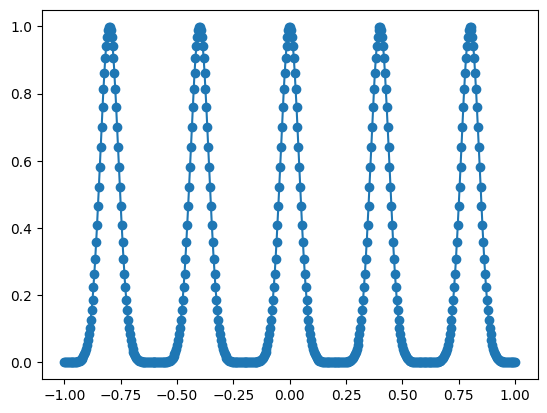

In [42]:
# Synthetic Data Generation
n_peak = 5
n_num_per_peak = 100
n_sample = n_peak * n_num_per_peak

x_grid = torch.linspace(-1, 1, steps=n_sample)
x_centers = 2 / n_peak * (np.arange(n_peak) - n_peak / 2 + 0.5)
x_sample = torch.stack([torch.linspace(-1 / n_peak, 1 / n_peak, steps=n_num_per_peak) + center for center in x_centers]).reshape(-1,)

y = 0
for center in x_centers:
    y += torch.exp(-(x_grid - center) ** 2 * 300)

y_sample = 0
for center in x_centers:
    y_sample += torch.exp(-(x_sample - center) ** 2 * 300)

plt.plot(x_grid.detach().numpy(), y.detach().numpy())
plt.scatter(x_sample.detach().numpy(), y_sample.detach().numpy())
plt.show()

In [ ]:
plt.subplots(1, 5, figsize=(15, 2))
plt.subplots_adjust(wspace=0, hspace=0)

for i in range(1,6):
    plt.subplot(1,5,i)
    group_id = i - 1
    plt.plot(x_grid.detach().numpy(), y.detach().numpy(), color='black', alpha=0.1)
    plt.scatter(x_sample[group_id*n_num_per_peak:(group_id+1)*n_num_per_peak].detach().numpy(), y_sample[group_id*n_num_per_peak:(group_id+1)*n_num_per_peak].detach().numpy(), color="black", s=2)
    plt.xlim(-1,1)
    plt.ylim(-1,2)

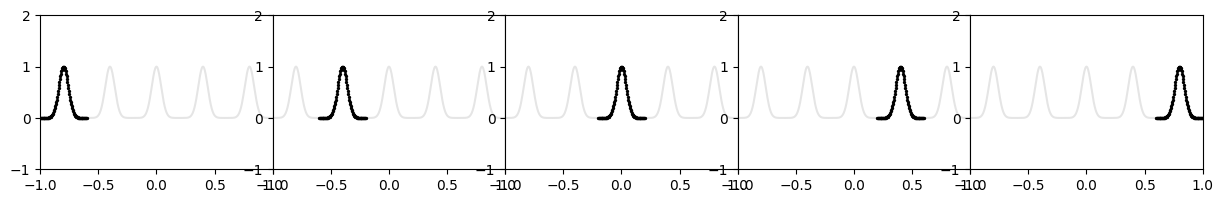

In [43]:
fig, axs = plt.subplots(1, 5, figsize=(15, 2))
fig.subplots_adjust(wspace=0, hspace=0)

for i in range(5):
    group_id = i
    axs[i].plot(x_grid.detach().numpy(), y.detach().numpy(), color='black', alpha=0.1)
    axs[i].scatter(x_sample[group_id * n_num_per_peak:(group_id + 1) * n_num_per_peak].detach().numpy(), y_sample[group_id * n_num_per_peak:(group_id + 1) * n_num_per_peak].detach().numpy(), color="black", s=2)
    axs[i].set_xlim(-1, 1)
    axs[i].set_ylim(-1, 2)


In [46]:
ys = []
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

epochs = 1000
all_train_data = []
all_train_labels = []

for group_id in range(n_peak):
    train_data = x_sample[group_id * n_num_per_peak:(group_id + 1) * n_num_per_peak][:, None]
    train_label = y_sample[group_id * n_num_per_peak:(group_id + 1) * n_num_per_peak][:, None]

    all_train_data.append(train_data)
    all_train_labels.append(train_label)

    for epoch in range(epochs):
        optimizer.zero_grad()

        combined_train_data = torch.cat(all_train_data, dim=0)
        combined_train_labels = torch.cat(all_train_labels, dim=0)

        outputs = model(combined_train_data)
        loss = criterion(outputs, combined_train_labels)
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}')

    y_pred = model(x_grid[:, None])
    ys.append(y_pred.detach().numpy()[:, 0])

Epoch 1/1000, Loss: 0.0000
Epoch 101/1000, Loss: 0.0000
Epoch 201/1000, Loss: 0.0000
Epoch 301/1000, Loss: 0.0000
Epoch 401/1000, Loss: 0.0001
Epoch 501/1000, Loss: 0.0000
Epoch 601/1000, Loss: 0.0000
Epoch 701/1000, Loss: 0.0000
Epoch 801/1000, Loss: 0.0000
Epoch 901/1000, Loss: 0.0000
Epoch 1/1000, Loss: 0.0091
Epoch 101/1000, Loss: 0.0000
Epoch 201/1000, Loss: 0.0000
Epoch 301/1000, Loss: 0.0000
Epoch 401/1000, Loss: 0.0000
Epoch 501/1000, Loss: 0.0000
Epoch 601/1000, Loss: 0.0000
Epoch 701/1000, Loss: 0.0000
Epoch 801/1000, Loss: 0.0000
Epoch 901/1000, Loss: 0.0000
Epoch 1/1000, Loss: 0.0048
Epoch 101/1000, Loss: 0.0000
Epoch 201/1000, Loss: 0.0000
Epoch 301/1000, Loss: 0.0000
Epoch 401/1000, Loss: 0.0000
Epoch 501/1000, Loss: 0.0000
Epoch 601/1000, Loss: 0.0000
Epoch 701/1000, Loss: 0.0000
Epoch 801/1000, Loss: 0.0004
Epoch 901/1000, Loss: 0.0000
Epoch 1/1000, Loss: 0.0193
Epoch 101/1000, Loss: 0.0000
Epoch 201/1000, Loss: 0.0000
Epoch 301/1000, Loss: 0.0000
Epoch 401/1000, Loss: 

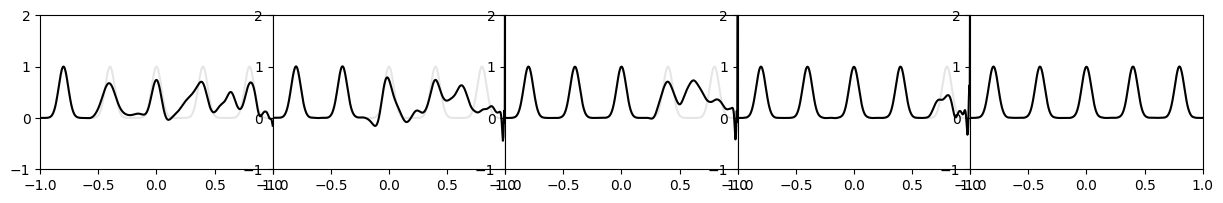

In [47]:
fig, axs = plt.subplots(1, 5, figsize=(15, 2))
fig.subplots_adjust(wspace=0, hspace=0)

for i in range(5):
    group_id = i
    axs[i].plot(x_grid.detach().numpy(), y.detach().numpy(), color='black', alpha=0.1)
    axs[i].plot(x_grid.detach().numpy(), ys[i], color='black')
    axs[i].set_xlim(-1, 1)
    axs[i].set_ylim(-1, 2)

plt.show()
